Working on N=2
Testing scipy+numpy
nfev 3 njev 1
Time for scipy + numpy 0.003027766322096189
Testing scipy + jitted function and numeric grad
nfev 3 njev 1
Time for scipy + jitted function and numeric grad 0.0008319343129793803
Testing LBFGS scipy + jitted function and numeric grad
Testing scipy + jitted function and grad
nfev 9 njev 9
Time for scipy + jitted function and grad 0.0028568890023355684
Testing pure JAX implementation
JAX f(optimal) 0.015511745 scipy+jax f(optimal) 0.015511743724346161
nfev 11 njev 11
Time for pure JAX implementation 0.001707219014254709
Testing pure L-BFGS JAX implementation
JAX f(optimal) 0.015511744 scipy+jax f(optimal) 0.015511743724346161
nfev 8 njev 8
Time for pure JAX implementation 0.001707219014254709
Working on N=10
Testing scipy+numpy
nfev 11 njev 1
Time for scipy + numpy 0.011491830344311893
Testing scipy + jitted function and numeric grad
nfev 11 njev 1
Time for scipy + jitted function and numeric grad 0.0016252719797194004
Testing LBFGS scipy 

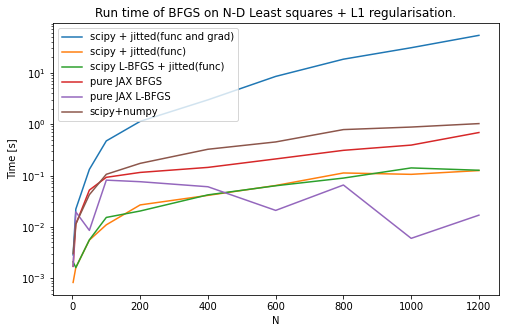

In [12]:
# Based on https://gist.github.com/Joshuaalbert/39e5e44a06cb00e7e154b37504e30fa1

import os
import numpy as np
from jax import jit, value_and_grad, random
import jax.numpy as jnp
from jax.scipy.optimize import minimize as minimize_jax
from scipy.optimize import minimize as minimize_np
import pylab as plt
from timeit import default_timer


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


def speed_test_jax():
    S = 3
    t_scipy_halfjax, t_scipy_jax, t_scipy_halfjax_lbfgs, t_jax, t_numpy, t_jax_lbfgs = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    N_array = [2, 10, 50, 100, 200, 400, 600, 800, 1000, 1200]
    for N in N_array:
        print("Working on N={}".format(N))

        A = random.normal(random.PRNGKey(0), shape=(N, N))
        u = jnp.ones(N)
        x0 = -2.0 * jnp.ones(N)

        def f_prescale(x, u):
            y = A @ x
            dx = u - y
            return jnp.sum(dx**2) + 0.1 * jnp.sum(jnp.abs(x))

        # Due to https://github.com/google/jax/issues/4594 we scale the loss
        # so that scipy and jax linesearch perform similarly.
        jac_norm = jnp.linalg.norm(value_and_grad(f_prescale)(x0, u)[1])
        jac_norm_np = np.array(jac_norm)

        def f(x, u):
            y = A @ x
            dx = u - y
            return (jnp.sum(dx**2) + 0.1 * jnp.sum(jnp.abs(x))) / jac_norm

        def f_np(x, u):
            y = A @ x
            dx = u - y
            return (np.sum(dx**2) + 0.1 * np.sum(np.abs(x))) / jac_norm_np

        print("Testing scipy+numpy")
        t0 = default_timer()
        args = (np.array(x0), (np.array(u),))
        results_np = minimize_np(f_np, *args, method="BFGS")
        for _ in range(S):
            results_np = minimize_np(f_np, *args, method="BFGS")
        t_numpy.append((default_timer() - t0) / S)
        print("nfev", results_np.nfev, "njev", results_np.njev)
        print("Time for scipy + numpy", t_numpy[-1])

        print("Testing scipy + jitted function and numeric grad")

        @jit
        def _f(x0, u):
            return f(x0, u)

        _f(x0, u).block_until_ready()
        t0 = default_timer()
        for _ in range(S):
            results_np = minimize_np(_f, x0, (u,), method="BFGS")
        t_scipy_halfjax.append((default_timer() - t0) / S)
        print("nfev", results_np.nfev, "njev", results_np.njev)
        print("Time for scipy + jitted function and numeric grad", t_scipy_halfjax[-1])

        print("Testing LBFGS scipy + jitted function and numeric grad")

        @jit
        def _f(x0, u):
            return f(x0, u)

        _f(x0, u).block_until_ready()
        t0 = default_timer()
        for _ in range(S):
            results_np = minimize_np(_f, x0, (u,), method="L-BFGS-B")
        t_scipy_halfjax_lbfgs.append((default_timer() - t0) / S)

        print("Testing scipy + jitted function and grad")

        @jit
        def _f(x0, u):
            v, g = value_and_grad(f)(x0, u)
            return v, g

        _f(x0, u)[1].block_until_ready()
        t0 = default_timer()
        for _ in range(S):
            results_np = minimize_np(_f, x0, (u,), method="BFGS", jac=True)
        t_scipy_jax.append((default_timer() - t0) / S)
        print("nfev", results_np.nfev, "njev", results_np.njev)
        print("Time for scipy + jitted function and grad", t_scipy_jax[-1])

        print("Testing pure JAX implementation")

        @jit
        def do_minimize_jax(x0, u):
            results = minimize_jax(f, x0, args=(u,), method="BFGS")
            return results.x

        results_jax = minimize_jax(f, x0, args=(u,), method="BFGS")
        print("JAX f(optimal)", results_jax.fun, "scipy+jax f(optimal)", results_np.fun)
        do_minimize_jax(x0, u).block_until_ready()
        t0 = default_timer()
        for _ in range(S):
            do_minimize_jax(x0, u).block_until_ready()
        t_jax.append((default_timer() - t0) / S)
        print("nfev", results_jax.nfev, "njev", results_jax.njev)
        print("Time for pure JAX implementation", t_jax[-1])

        print("Testing pure L-BFGS JAX implementation")

        @jit
        def do_minimize_jax(x0, u):
            results = minimize_jax(
                f, x0, args=(u,), method="l-bfgs-experimental-do-not-rely-on-this"
            )
            return results.x

        results_jax = minimize_jax(
            f, x0, args=(u,), method="l-bfgs-experimental-do-not-rely-on-this"
        )
        print("JAX f(optimal)", results_jax.fun, "scipy+jax f(optimal)", results_np.fun)
        do_minimize_jax(x0, u).block_until_ready()
        t0 = default_timer()
        for _ in range(S):
            do_minimize_jax(x0, u).block_until_ready()
        t_jax_lbfgs.append((default_timer() - t0) / S)
        print("nfev", results_jax.nfev, "njev", results_jax.njev)
        print("Time for pure JAX implementation", t_jax[-1])

    plt.figure(figsize=(8, 5))
    plt.plot(N_array, t_scipy_jax, label="scipy + jitted(func and grad)")
    plt.plot(N_array, t_scipy_halfjax, label="scipy + jitted(func)")
    plt.plot(N_array, t_scipy_halfjax_lbfgs, label="scipy L-BFGS + jitted(func)")
    plt.plot(N_array, t_jax, label="pure JAX BFGS")
    plt.plot(N_array, t_jax_lbfgs, label="pure JAX L-BFGS")
    plt.plot(N_array, t_numpy, label="scipy+numpy")
    plt.yscale("log")
    plt.legend()
    plt.title("Run time of BFGS on N-D Least squares + L1 regularisation.")
    plt.ylabel("Time [s]")
    plt.xlabel("N")
    plt.show()


if __name__ == "__main__":
    speed_test_jax()